# LWIR Filters Artifact Undistort

# Problem Description
When capturing real-world scenes using TAU2, an unexpected and unclear spherical distortion appears when applying an IR filter.
This artifact only appears when applying a filter, as can be seen from the following example:


In [23]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

data_base_dir = Path(
    r"C:\Users\omriber\Documents\Thesis\MultiSpectralCtrl\download")

data_fname = "cnt1_20210830_h15m53s38.npy"
data = np.load(Path(data_base_dir, data_fname))

fig = make_subplots(1, 2)
fig = px.imshow(data[0, 0], color_continuous_scale='gray',
                title="Pan-Chromatic")

fig.show()
fig = px.imshow(data[1, 0], color_continuous_scale='gray', title="Filter1")
fig.show()


While seemingly similar to vignetting, it's clearly not, as in opposed to vignetting, the center is brighter than the edges (in vignetting its vice-versa).

Moreover, many pixels have a higher intensity level when the filter is applied, in contrast to the expected physical phenomenon, by which the grey level is proportional to the radiated power. This can be clerly observed when using the same dynamic range for showing both images:

In [ ]:
fig = px.imshow(data[:2, 0, ...], facet_col=0,
                color_continuous_scale='gray')
fig.layout.annotations[0].text="Pan-Chromatic"
fig.layout.annotations[1].text="Filtered"
fig.show()


This might suggest that some pre-processing is still occuring during image acquisition, despite being canceled by Navot's commands.

# Physical Model
To tackle the observed issue, we must first assume some model the generated distortion in the grey-levels.
I propose the following linear model:
$$ GL^{(f)}_{i,j} = \alpha_{i,j}P^{(f)}(T) + \beta_{i,j}^{(f)} + n_{i,j}$$
Where:
* $GL^{(f)}_{i,j}$ are the grey level of the i,j'th pixel (per filter).
* $P^{(f)}(T)$ is the radiance power (per filter), which can be calculated analytically based on Plank's law.
* $\alpha_{i,j}$ are the per-pixel slopes of the liner model.
* $\beta_{i,j}^{(f)}$ is the linear model bias (perhaps not pixel-dependent).
* $n$ is the per-pixel additive noise. 

My assumption is that $\alpha_{i,j}$ should be the same for all filters, including the case where no filter is applied (A.K.A the pan-chromatic case). Hence, we could use "undistorted" pan-chromatic acquisitions to estimate $\alpha_{i,j}$, and combined with plank's law, to estimate the expected filtered scenes. The difference between the estimated scenes and the de-facto acquired scenes will be the distortion that we are looking for.

# Suggested Undistortion Calibration Workflow:
To overcome the observed distortion, I propose the following workflow:
* Per spatial pixel i,j:
    1. Estimate $\alpha_{i,j}$, the per-pixel scale-factor converting from radiance power to grey-level:
        1. Capture an unfiltered image (pan-chromatic) of the black-body in several temperature set-points, to obtain a grey level per-pixel $GL^{\text{pan}}_{i,j}$
        2. Analytically calculate the expected radiance power by integrating over Plank's spectral radiance density $B(\lambda, T)$: 
            $$P^{\text{pan}}(\lambda^{\text{pan}}_{0,1}, T) = \int_{\lambda^{\text{pan}}_0}^{\lambda^{\text{pan}}_1} B(\lambda, T) d\lambda$$
            Where $B(\lambda, T) = \frac{2h/c^2\lambda^3}{exp(h/KT\lambda)-1}$ is Plank's spectral radiance density, and $\lambda^{\text{pan}}_{0,1}$ should be determined by TAU's natural band-width (After looking at the camera's SPEC, it seems that $\lambda_0=7.5\mu m, \: \lambda_1=13.5\mu m$). 
            
            Alternatively, and assuming an infinite bandwidth with optimal transmission response, we can use the Stefan–Boltzmann law to assert that $P^{\text{pan}} = \frac{1}{\pi} \sigma T^4 $
        3. Use linear regression ($GL_{i,j}^{\text{pan}}$ vs $\hat{P}^{\text{pan}}$) to estimate the pan-chromatic $\hat{\alpha}_{i,j}^{\text{pan}}$ and $\hat{\beta}^{\text{pan}}$.
        4. Estimate $\alpha_{i,j}$ using $\hat{\alpha}_{i,j} = \frac{GL^{\text{pan}}_{i,j}-\hat{\beta}^{\text{pan}}}{P^{\text{pan}}}$
        <!-- 5. Repeat for every temperature set-point to obtain a (linear) regression model for $\hat{\alpha}_{i,j}(T) = a_0T + b_0$ -->
    2. Estimate $\delta^{(f)}_{i,j}$, the per-pixel, per-filter distortion correction coefficients. For each filter (f):
        1. Capture a filtered image of the black-body in several temperature set-points, to obtain a grey level per-pixel $GL^{(f)}_{i,j}$
        2. Analytically calculate the expected radiance power by integrating over Plank's spectral radiance density $B(\lambda, T)$: 
            $$P^{(f)}(\lambda_{0,1}, T) = \int_{\lambda_0}^{\lambda_1} B(\lambda, T) f(\lambda) d\lambda$$
            Where now $\lambda_{0,1}$ are determinde by the filter's band-width, and $f(\lambda)$ is the filter's transmitanse response. This time, as a significant portion of the spectrum is cut-off, the Stefan–Boltzmann law can no longer be used to approximate the integral.
        3. Estimate the per-filter bias using the already-estimated $\hat{\alpha}_{i,j}$: $\hat{\beta}^{(f)} = GL^{(f)}_{i,j} - \hat{\alpha}_{i,j}P^{(f)}$. Since we require $\hat{\beta}^{(f)}$ to be constant, the problem is over-constrained, and we could solve for the optimal bias term using optimization (e.g. least-squares).
        4. Use the optimal bias found in (3) to construct a synthetic "expected" grey-level image: $\hat{GL}^{(f)}_{i,j} = \hat{\alpha}_{i,j}P^{(f)} + \hat{\beta}^{(f)}$
        5. In this point, we can compare our expectated image $\hat{GL}^{(f)}_{i,j}$, which is a constant grey-level across all pixels by design, to the actual image $GL^{(f)}_{i,j}$, which suffers from vignetting and possibly other filter-related per-pixel distortions (\delta^{(f)}_{i,j}). The estimation of $\delta^{(f)}_{i,j}$ is still an open issue, and could be of the form of $\hat{\delta}^{(f)}_{i,j} = \frac{\hat{GL^{(f)}_{i,j}}}{GL^{(f)}_{i,j}}$ of maybe $\hat{\delta}^{(f)}_{i,j} = \hat{GL^{(f)}_{i,j}} - GL^{(f)}_{i,j}$ or even a combination of the two (linear model). The answer to that isn't clear, and will maybe become so after exploring the results of previous steps.
        <!-- 5. Repeat for every temperature set-point to obtain a (linear) regression model for $\hat{\beta}^{(f)}_{i,j}(T) = a_1T + b_1$ -->


# Calculating the Power-Radiance P:
use the API as depicted below:

Input temperature: 32.0000
Estimated temperature (by integrating over plank's function): 31.9996


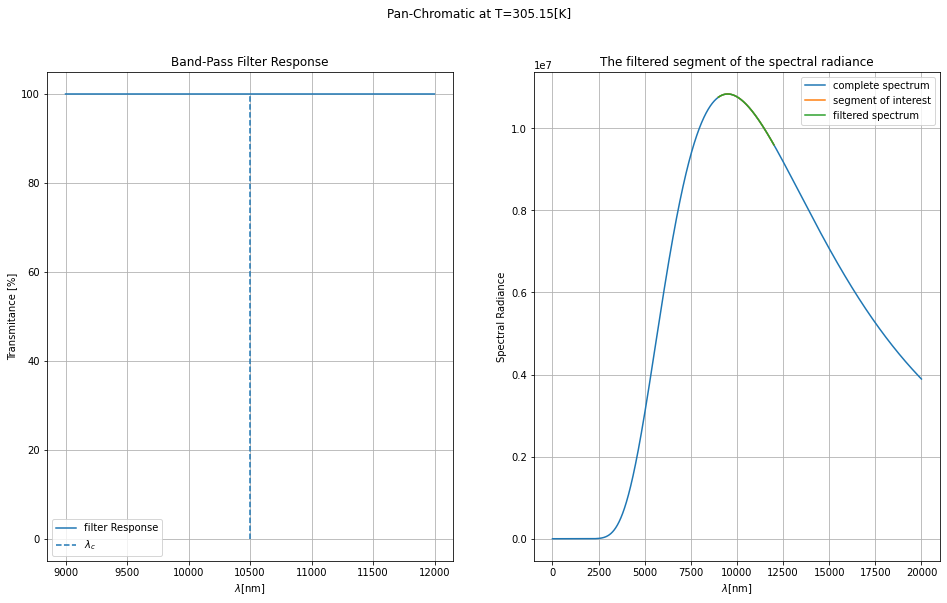

Input temperature: 32.0000
Estimated temperature (by integrating over plank's function): 31.9996


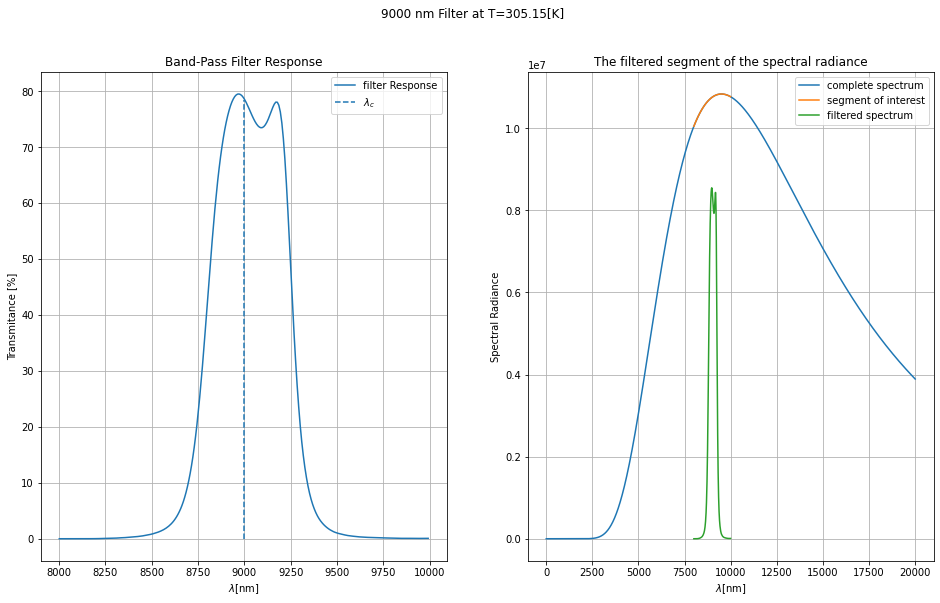

In [ ]:
from tools import calc_rx_power
import numpy as np
import matplotlib.pyplot as plt
# for pan-chromatic, currently using an ideal, infinitely wide bandwidth filter assumption
rx_power = calc_rx_power(temperature=32, debug=True)


# for a specific filter, provide the central frequency:
lambda_c = 9000 #[nm]
rx_power = calc_rx_power(temperature=32, central_wl=lambda_c, bw=1000, is_ideal_filt=False, debug=True)


To avoid generating the figures each time the calculation is invoked, simply set debug=false (or completely remove it as an argument)

---

# Preparations: Importing essential packages and loading the data:

In [1]:
%load_ext autoreload
%autoreload 2

from tools import calc_rx_power, get_meas, prefilt_cam_meas, SpectralFilter
import matplotlib.pyplot as plt
import numpy as np
from multiprocessing import Pool, cpu_count
from scipy.optimize import nnls
from itertools import product
from tqdm import tqdm
from pathlib import Path

path_to_files = Path("rawData/01_09_21")


# Step 0: Model validation
To understand whether our model is right, we first need to see if the relationship between the panchromatic grey-levels $GL^{\text{Pan}}$ and the radiated power $P^{\text{Pan}}$ is indeed linear and with what coefficients

## Load the panchromatic data:


In [2]:
temps_to_ommit = [60]
meas_panchromatic, list_power_panchormatic, list_blackbody_temperatures = get_meas(
    path_to_files, ommit_ops=temps_to_ommit)
meas_panchromatic_clean = prefilt_cam_meas(meas_panchromatic)
del meas_panchromatic

Load measurements: 100%|██████████| 11/11 [01:08<00:00,  6.27s/it]


## Plot Grey levels of random pixels Vs power

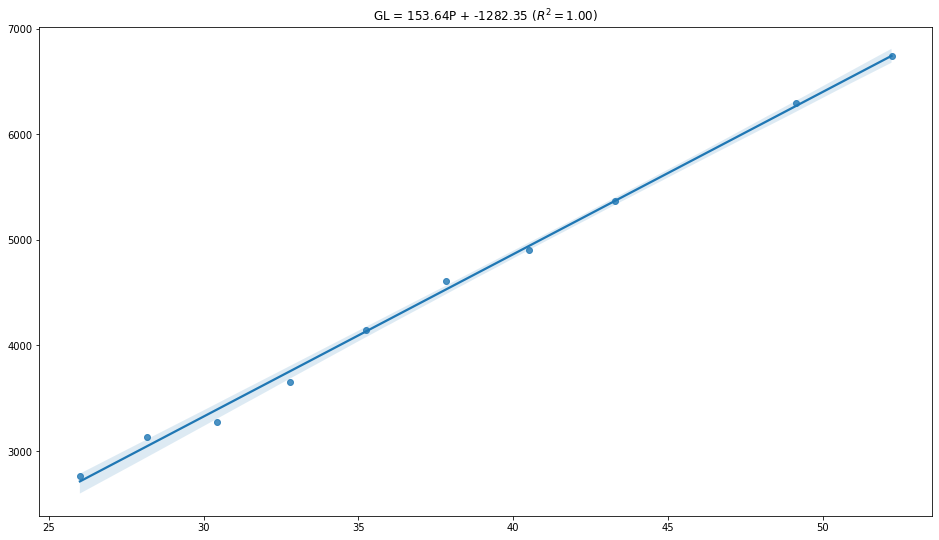

In [22]:
import seaborn as sns
from sklearn.linear_model import LinearRegression

meas_panchromatic_clean_mean = meas_panchromatic_clean.mean(axis=1)
i, j = 50, 200
plt.figure(figsize=(16, 9))
sns.regplot(x=list_power_panchormatic, y=meas_panchromatic_clean_mean[:, i, j])
lr = LinearRegression()
reg_res = lr.fit(np.array(list_power_panchormatic)[:, None], meas_panchromatic_clean_mean[:, i, j])
r2 = lr.score(np.array(list_power_panchormatic)[
            :, None], meas_panchromatic_clean_mean[:, i, j])
plt.title(
    f"GL = {reg_res.coef_[0]:.2f}P + {reg_res.intercept_:.2f} ($R^2={r2:.2f}$)")
params = reg_res.get_params()


Seems like the regression model is indeed linear, with a non-negligible bias term. 

# Step 1: estimate $\alpha_{i,j}$

## Estimate the bias $\hat{\beta}^{\text{pan}}$ (1.3)

In [11]:
beta_pan = meas_panchromatic_clean.mean(axis=(1, 2, 3))

## Estimate $\alpha_{i,j}$ (1.4). Non-vectorized implementation is used to avoid RAM abuse.

In [12]:
alpha = np.empty_like(meas_panchromatic_clean, dtype=float)
for i, op_power in enumerate(list_power_panchormatic):
    alpha[i] = meas_panchromatic_clean[i] - beta_pan[i] / op_power


<!-- ## Get a linear regression model for $\alpha_{i,j}(T)$ -->

In [6]:
# from sklearn.linear_model import LinearRegression

# meas_shape = meas_panchromatic_clean.shape
# lr = LinearRegression()
# lr_res = {"slopes": np.zeros(
#     meas_shape[2:]), "intercepts": np.zeros(meas_shape[2:])}
# lr_all = np.zeros(meas_shape[2:])

# # ## prepare variables for regression:
# x = np.array(list_power_panchormatic).repeat(meas_panchromatic_clean.shape[1])[:, np.newaxis]
# y = meas_panchromatic_clean.T.reshape(-1, meas_shape[2] * meas_shape[3])


# for i in range(meas_shape[2]):
#     for j in range(meas_shape[3]):
#         lr_ij = lr.fit(x, meas_panchromatic_clean[..., i, j].flatten())
#         lr_res["slopes"][i, j] = lr_ij.coef_
#         lr_res["intercepts"][i, j] = lr_ij.intercept_


# ## Plot results:
# import plotly.express as px

# fig = px.imshow(lr_res["slopes"], color_continuous_scale='gray', title="Linear Regression Slopes Map")
# fig.show()

# fig = px.imshow(lr_res["intercepts"], color_continuous_scale='gray', title="Linear Regression Intercepts Map")
# fig.show()


# Step 2: estimate $\delta^{(f)}_{i,j}$


## Calculate the expected radiance power per filter (2.2) and estimate the per-filter bias $\hat{\beta}^{(f)}$ (2.3)

In [24]:
import pandas as pd
# for a specific filter, provide the central frequency:

# Prepare containers for processed data:
filters_cw = [filt.value for filt in SpectralFilter if filt.value > 0]
power_filt = pd.DataFrame(index=list_blackbody_temperatures, columns=filters_cw)
beta_filt = power_filt.copy()


# Gather variables required for next block to save redundent calculations:
meas_shape = meas_panchromatic_clean.shape
meas_filt_all = np.empty((len(filters_cw), meas_shape[0], *meas_shape[2:]))

# Process data:
for i, filter_cw in enumerate(filters_cw):
    meas_filt, _, _ = get_meas(path_to_files, SpectralFilter(
        filter_cw), ommit_ops=temps_to_ommit)
    meas_filt_clean = prefilt_cam_meas(meas_filt)
    meas_filt_all[i] = meas_filt_clean.mean(axis=1)
    for temperature in list_blackbody_temperatures:
        power_filt.loc[temperature, filter_cw] = calc_rx_power(
            temperature=temperature, central_wl=filter_cw, bw=1000, is_ideal_filt=False)
        beta_filt.loc[temperature, filter_cw] = meas_filt_clean[i].mean()


Load measurements: 100%|██████████| 11/11 [00:44<00:00,  4.09s/it]


### Load Panchromatic

### Load Filters

In [ ]:
dict_measurements = {}

paths = list(path_to_files.glob('*.npy'))
for path in tqdm(paths, desc="Load measurements"):
    temperature_blackbody = int(path.stem.split('_')[-1])
    try:
        meas = np.load(str(path))
    except ValueError:
        print(f'Cannot load file {str(path)}')
        continue
    list_filters = sorted(pd.read_csv(path.with_suffix('.csv')).to_numpy()[:,1])
    for idx, filter_name in enumerate(list_filters):
        dict_measurements.setdefault(temperature_blackbody, {}).setdefault(filter_name, meas[idx])
dict_measurements = {k:dict_measurements[k] for k in sorted(dict_measurements.keys())}
print(f'Available filtes: {list_filters}nm')
list_blackbody_temperatures = list(dict_measurements.keys())
print(f'BlackBody reference temperatures: {list_blackbody_temperatures}C')